In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.animation import PillowWriter
%matplotlib inline

# ----------------------------
# Physical parameters
# ----------------------------
g = 9.81   # gravitational acceleration (m/s^2)
L = 50000 # domain length (m)
nx = 500  # number of grid points
dx = L / (nx - 1)
x = np.linspace(0, L, nx)
h_bg = 100     # background depth of water body (m)

DiffusionOn = True # Use to add diffusion to velocity
nu = 10e-1 # Eddy diffusion (m^2/s)

# ----------------------------
# Time parameters
# ----------------------------
dt = 1.0  # time step (s)
T  = 36000 # Duration of run (s)
nt = int(T/dt) # number of time steps
t  = dt*np.arange(nt+1) # create a time vector for plotting
output_every = 100 # Frame output interval for animation


Text(0.5, 0, 'Distance')

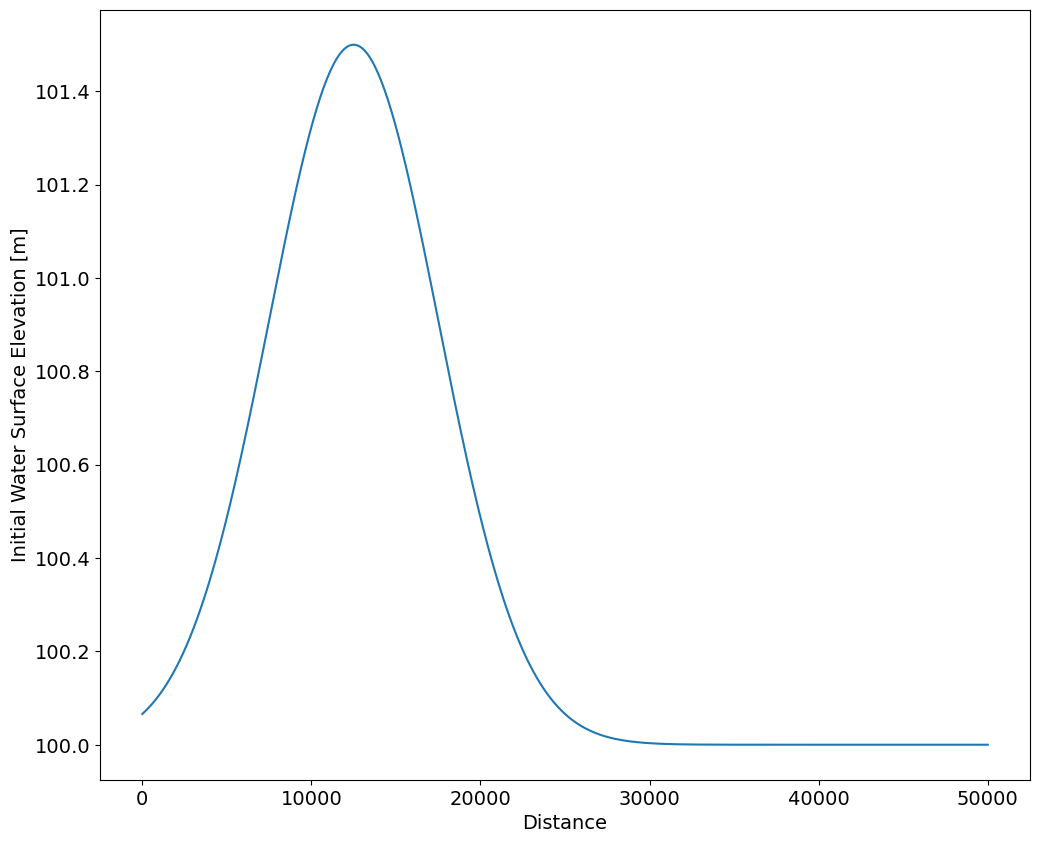

In [2]:
# ----------------------------
# Initial condition
# ----------------------------
h0 = h_bg * np.ones(nx) # Background depth, distributed (m)
u0 = np.zeros(nx)   # initial velocity (m/s)

# Add a small Gaussian perturbation in water height
perturb_center = L/4
perturb_width = 5e3
perturb_height = 1.5

h0 += perturb_height * np.exp(-((x - perturb_center)**2) / (2 * perturb_width**2))

plt.rcParams.update({'font.size': 14})
plt.figure(figsize=(12,10))
plt.plot(x,h0)
plt.ylabel('Initial Water Surface Elevation [m]')
plt.xlabel('Distance')


In [3]:
# Initialize arrays
h = h0
u = u0

h_record = np.zeros((nx,nt+1))
u_record = np.zeros((nx,nt+1))

In [4]:
# ----------------------------
# MacCormack Method
# ----------------------------
save_counter = 0

h_record[:,0] = h
u_record[:,0] = u

alpha = dt/dx

for n in range(nt):
    # Predictor step
    h = h_record[:,n]
    u = u_record[:,n]
    h_pred = np.zeros((nx))
    u_pred = np.zeros((nx))
    h_corr = np.zeros((nx))
    u_corr = np.zeros((nx))
    
    # Avoid indexing errors
    for i in range(nx - 1):
        h_pred[i] = h[i] - alpha*(h[i+1] * u[i+1] - h[i] * u[i])
        u_pred[i] = u[i] - alpha*u[i]*(u[i+1] - u[i]) - g*alpha*(h[i+1]-h[i])

    # Corrector step
    for i in range(1, nx):
        h_corr[i] = 0.5*(h[i]+h_pred[i] - alpha*(u_pred[i]*h_pred[i] - u_pred[i-1]*h_pred[i-1]))
        u_corr[i] = 0.5*(u[i]+u_pred[i] - alpha*u_pred[i]*(u_pred[i] - u_pred[i-1]) - g*alpha*(h_pred[i]-h_pred[i-1]))
    
    cfl = np.max(np.abs(u_corr) + np.sqrt(g*h_corr))*dt/dx
    if cfl > 1:
        print(f'Exceeding CFL limit. CFL = {cfl:.2f} at time step {n}. Consider reducing dt.')

    # Reflective boundary conditions
    h_corr[0] = h_corr[1]
    h_corr[-1] = h_corr[-2]
    u_corr[0] = -u_corr[1]
    u_corr[-1] = -u_corr[-2]

    if (DiffusionOn == True):
        u_diff = np.zeros((nx))
        if((2*nu*dt)/(dx**2) > 1):
            print(f'Diffusion stability limit reached {(2*nu*dt)/(dx**2):.2f}. Consider reducing timestep, increasing spatial step, or reducing eddy diffusivity')
        for i in range(1, nx - 1):
            u_diff[i] = u_corr[i] + nu * dt / dx**2 * (u_corr[i+1] - 2*u_corr[i] + u_corr[i-1])
        u_corr = u_diff
    
    # Reflective boundary conditions
    h_corr[0] = h_corr[1]
    h_corr[-1] = h_corr[-2]
    u_corr[0] = -u_corr[1]
    u_corr[-1] = -u_corr[-2]
    
    h_record[:,n+1] = h_corr
    u_record[:,n+1] = u_corr


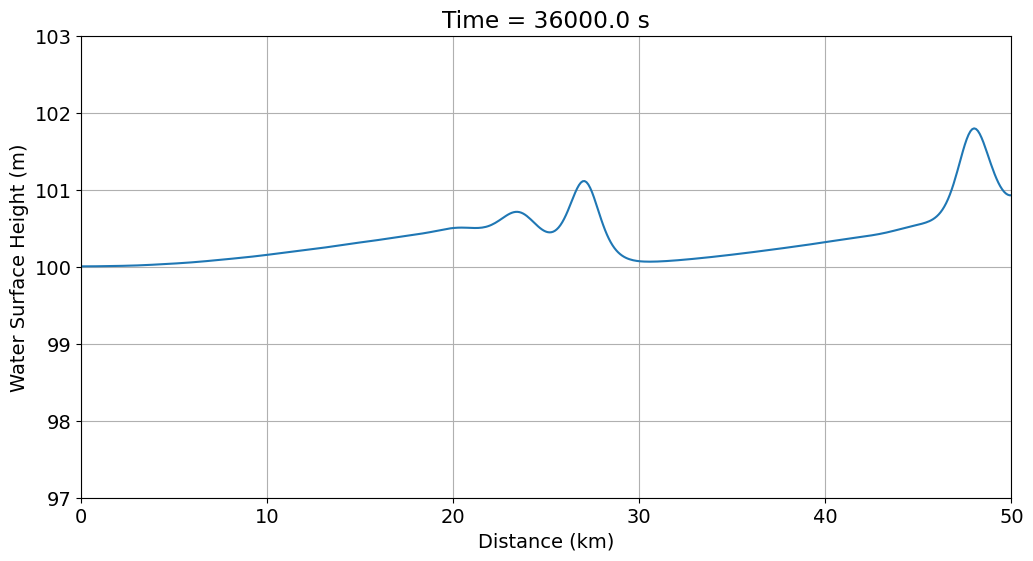

In [ ]:
# ----------------------------
# Animation
# ----------------------------
fig, ax = plt.subplots(figsize=(12, 6))
line, = ax.plot(x/1e3 , h_record[:,0], label='Water Height')
ax.set_ylim(h_bg - 2*perturb_height, h_bg + 2*perturb_height)
ax.set_xlim(0, x.max()/1e3)
ax.set_xlabel('Distance (km)')
ax.set_ylabel('Water Surface Height (m)')
ax.set_title('1D Shallow Water Waves (Reflective Boundaries)')
ax.grid(True)

def update(frame):
    line.set_ydata(h_record[:,frame])
    ax.set_title(f"Time = {frame*dt:.1f} s")
    return line,

anim = FuncAnimation(fig, update, frames=range(0,h_record.shape[1],output_every),interval=50)
anim.save("swe_animation.gif", writer=PillowWriter(fps=60))
plt.show()

Text(0.5, 0, 'Time (s)')

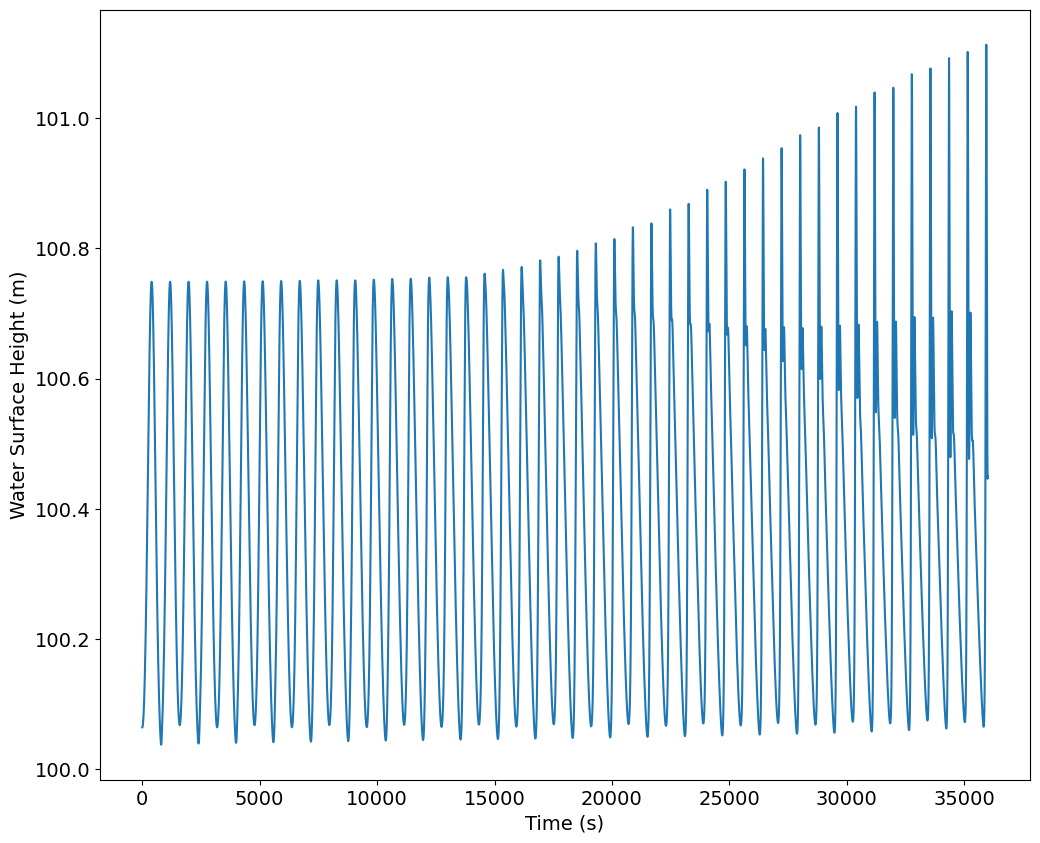

In [6]:
# Plot wave heights through time in the middle of the domain
plt.rcParams.update({'font.size': 14})
plt.figure(figsize=(12,10))
plt.plot(t,h_record[int(nx/2),:])
plt.ylabel('Water Surface Height (m)')
plt.xlabel('Time (s)')

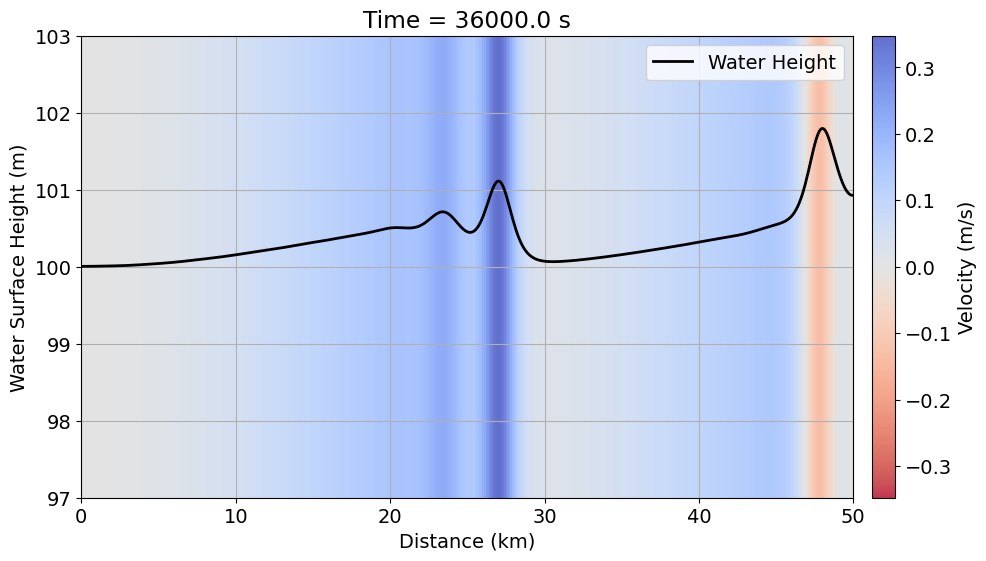

In [ ]:
# Transpose h_record and u_record if needed
nt = h_record.shape[1]
nx = h_record.shape[0]
H = h_record.T  # shape: (nt, nx)
U = u_record.T  # shape: (nt, nx)

# Global min/max velocity for color scale
vmin = -np.max(np.abs(U))
vmax = np.max(np.abs(U))

# ----------------------------
# Animation: height + velocity colormap
# ----------------------------
fig, ax = plt.subplots(figsize=(12, 6))

# Initialize velocity colormap (1 row of U for current time)
vmin = -np.max(np.abs(U))
vmax = np.max(np.abs(U))
velocity_img = ax.imshow(U[0][np.newaxis, :],
                         extent=[x.min()/1e3, x.max()/1e3, h_bg - 2*perturb_height, h_bg + 2*perturb_height],
                         aspect='auto',
                         cmap='coolwarm_r',
                         vmin=vmin,
                         vmax=vmax,
                         interpolation='nearest',
                         alpha=0.8)

# Add colorbar
cbar = fig.colorbar(velocity_img, ax=ax, orientation='vertical', pad=0.02)
cbar.set_label("Velocity (m/s)")

# Water height line
line, = ax.plot(x/1e3, H[0], color='black', linewidth=2, label='Water Height')

# Aesthetic setup
ax.set_xlim(x.min()/1e3, x.max()/1e3)
ax.set_ylim(h_bg - 2*perturb_height, h_bg + 2*perturb_height)
ax.set_xlabel('Distance (km)')
ax.set_ylabel('Water Surface Height (m)')
ax.set_title('Shallow Water Wave + Velocity Field')
ax.legend()
ax.grid(True)

# Update function
def update(frame):
    line.set_ydata(H[frame])
    velocity_img.set_data(U[frame][np.newaxis, :])
    ax.set_title(f"Time = {frame * dt:.1f} s")
    return line, velocity_img

# Animate
anim = FuncAnimation(fig, update, frames=range(0, nt, output_every), interval=50)
anim.save("swe_overlay_velocity.gif", writer=PillowWriter(fps=60))
plt.show()
